In [2]:
# !pip install wilds
# !pip install git+https://github.com/openai/CLIP.git

In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from copy import deepcopy
import json 
from pathlib import Path
from typing import Callable, Dict, List, Optional, Sequence, Tuple, Union
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import clip
import wilds

import torch
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler, ConcatDataset
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# import timm
from importlib import reload
import utils 
reload(utils)

<module 'utils' from '/u/luchar/data-valuation/utils.py'>

## ImageNet

In [13]:
df = pd.read_csv('imagenet.csv', index_col=0)

data_dir = Path('../data')
img_val = data_dir / 'imagenet-val-set'
img_v2 = data_dir/ 'imagenetv2-matched-frequency-format-val'
img_a = data_dir / 'imagenet-a'
img_r = data_dir / 'imagenet-r'
img_s = data_dir / 'sketch'
# img_e = data_dir / 'imagenet-e'

In [14]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)
train_preprocessing = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # normalize,
])
test_preprocessing = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # normalize,
])

In [15]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)
train_preprocessing = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # normalize,
])
test_preprocessing = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # normalize,
])

In [138]:
reload(utils)

n = 1000

kwargs = dict(eval_mode=True, transforms=train_preprocessing, test_transforms=test_preprocessing)

val_ds = utils.DS(img_val, class_df=df.copy(), **kwargs)
v2_ds = utils.DS(img_v2, class_df=df.copy(), domain=None, **kwargs)
a_ds = utils.DS(img_a, class_df=df.copy(), domain=None, **kwargs)
r_ds = utils.DS(img_r, class_df=df.copy(), domain=None, **kwargs)
s_ds = utils.DS(img_s, class_df=df.copy(), domain=None, **kwargs)

found 50000 images
found 10000 images
found 7500 images
found 30000 images
found 50889 images


In [139]:
# plt.imshow(s_ds[3][0].moveaxis(0, -1).numpy())

## CELEB Faces

In [19]:
reload(utils)
celeb = data_dir / 'celeba_hq/val'
male = celeb / 'male'
female = celeb / 'female'
male_ds = utils.DS(male, **kwargs)
female_ds = utils.DS(female, **kwargs)

found 1000 images
found 1000 images


## WILDS

In [2]:
root_dir = '../data/wilds/'
iwildcam = wilds.get_dataset(dataset='iwildcam', root_dir=root_dir)
fmow = wilds.get_dataset(dataset='fmow', root_dir=root_dir)
# poverty = wilds.get_dataset(dataset='poverty', root_dir=root_dir)
amazon = wilds.get_dataset(dataset='amazon', root_dir=root_dir)
# civil = wilds.get_dataset(dataset='civilcomments', root_dir=root_dir)
# py150 = wilds.get_dataset(dataset='py150', root_dir=root_dir)

In [3]:
iwildcam_id_train = iwildcam.get_subset('train')
iwildcam_id_val = iwildcam.get_subset('id_val')
iwildcam_id_test = iwildcam.get_subset('id_test')
iwildcam_od_val = iwildcam.get_subset('val')
iwildcam_od_test = iwildcam.get_subset('test')

fmow_id_train = fmow.get_subset('train')
fmow_id_val = fmow.get_subset('id_val')
fmow_id_test = fmow.get_subset('id_test')
fmow_od_val = fmow.get_subset('val')
fmow_od_test = fmow.get_subset('test')

# poverty_id_train = poverty.get_subset('train')
# poverty_id_val = poverty.get_subset('id_val')
# poverty_id_test = poverty.get_subset('id_test')
# poverty_od_val = poverty.get_subset('val')
# poverty_od_test = poverty.get_subset('test')


amazon_id_train = amazon.get_subset('train')
amazon_id_val = amazon.get_subset('id_val')
amazon_id_test = amazon.get_subset('id_test')
amazon_od_val = amazon.get_subset('val')
amazon_od_test = amazon.get_subset('test')

# civil_id_train = civil.get_subset('train')
# civil_id_val = civil.get_subset('id_val')
# civil_id_test = civil.get_subset('id_test')
# civil_od_val = civil.get_subset('val')
# civil_od_test = civil.get_subset('test')

# py150_id_train = py150.get_subset('train')
# py150_id_val = py150.get_subset('id_val')
# py150_id_test = py150.get_subset('id_test')
# py150_od_val = py150.get_subset('val')
# py150_od_test = py150.get_subset('test')

In [4]:
clip_model, preprocess = clip.load("ViT-B/32", device='cuda', jit=False)
_transforms = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # preprocess,
])

In [20]:
eff_model = utils.create_model(arch='eff-b1').cuda()
eff_model.eval();
# eff_opt = utils.create_optimizer(val_model, lr=lr)

In [23]:
eff_model(val_ds[0][0][None].cuda()).shape

torch.Size([1, 1000])

In [ ]:
y = clip_model.encode_text(clip.tokenize(amazon_id_train[0][0]).cuda())

In [11]:
np.random.choice(np.arange(10))

9

In [114]:
def get_image_features(model, dataset, num_samples=1000, transforms=None):
    features = []
    for i in tqdm(range(num_samples), total=num_samples):
        image = dataset[i][0]
        if transforms is not None:
            image = transforms(image)
        features.append(model(image[None].cuda()).detach().cpu())
        
    torch.cuda.empty_cache()
    return torch.cat(features)

def get_clip_image_features(dataset, num_samples=1000, clip_model=clip_model, preprocess=preprocess):
    features = []
    to_pil = transforms.ToPILImage()
    for i in tqdm(range(num_samples), total=num_samples):
        image = dataset[i][0]
        if isinstance(image, torch.Tensor):
            image = to_pil(image)
        image = preprocess(image)[None]
        features.append(clip_model.encode_image(image.cuda()).detach().cpu())
        
    torch.cuda.empty_cache()
    return torch.cat(features)

def get_clip_text_features(dataset, num_samples=1000, clip_model=clip_model, max_token_length=77):
    features = []
    for i in tqdm(range(num_samples), total=num_samples):
        text = dataset[i][0]
        random_start = np.random.choice(np.arange(max(1, len(text) - max_token_length)))
        text = clip.tokenize(text[random_start:random_start + max_token_length])
        features.append(clip_model.encode_text(text.cuda()).detach().cpu())
        
    torch.cuda.empty_cache()
    return torch.cat(features)


In [8]:
num_samples = 1000

## Efficientnet embeddings

In [24]:
eff_imagenet_val_features = get_image_features(eff_model, val_ds, num_samples=num_samples, transforms=None)
eff_imagenet_v2_features = get_image_features(eff_model, v2_ds, num_samples=num_samples, transforms=None)
eff_imagenet_a_features = get_image_features(eff_model, a_ds, num_samples=num_samples, transforms=None)
eff_imagenet_s_features = get_image_features(eff_model, s_ds, num_samples=num_samples, transforms=None)
eff_imagenet_r_features = get_image_features(eff_model, r_ds, num_samples=num_samples, transforms=None)

eff_male_features = get_image_features(eff_model, male_ds, num_samples=num_samples, transforms=None)
eff_female_features = get_image_features(eff_model, female_ds, num_samples=num_samples, transforms=None)

In [26]:
eff_iwildcam_id_train_features = get_image_features(eff_model, iwildcam_id_train, num_samples=num_samples, transforms=_transforms)
eff_iwildcam_id_val_features = get_image_features(eff_model, iwildcam_id_val, num_samples=num_samples, transforms=_transforms)
eff_iwildcam_id_test_features = get_image_features(eff_model, iwildcam_id_test, num_samples=num_samples, transforms=_transforms)
eff_iwildcam_od_val_features = get_image_features(eff_model, iwildcam_od_val, num_samples=num_samples, transforms=_transforms)
eff_iwildcam_od_test_features = get_image_features(eff_model, iwildcam_od_test, num_samples=num_samples, transforms=_transforms)

eff_fmow_id_train_features = get_image_features(eff_model, fmow_id_train, num_samples=num_samples, transforms=_transforms)
eff_fmow_id_val_features = get_image_features(eff_model, fmow_id_val, num_samples=num_samples, transforms=_transforms)
eff_fmow_id_test_features = get_image_features(eff_model, fmow_id_test, num_samples=num_samples, transforms=_transforms)
eff_fmow_od_val_features = get_image_features(eff_model, fmow_od_val, num_samples=num_samples, transforms=_transforms)
eff_fmow_od_test_features = get_image_features(eff_model, fmow_od_test, num_samples=num_samples, transforms=_transforms)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:27<00:00, 11.36it/s]


In [85]:
figure_dir = Path('figures')
figure_dir.mkdir(exist_ok=True)

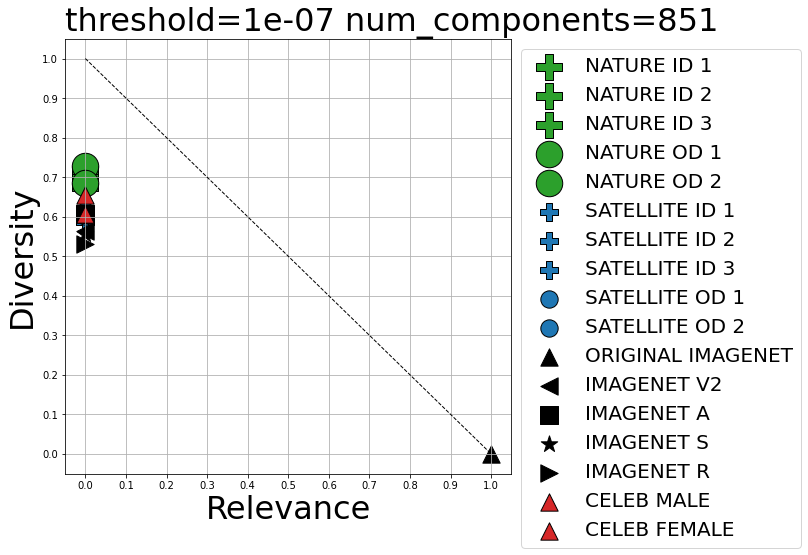

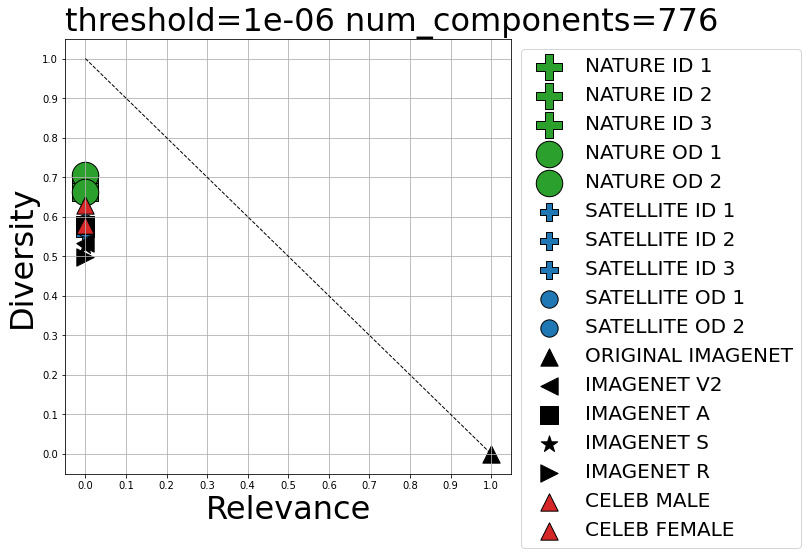

In [135]:
buyer = 'imagenet'
# buyer = 'male'
# buyer = 'iwildcam'
# buyer = 'fmow'
# buyer = 'amazon'

if buyer == 'imagenet':
    buyer_features = eff_imagenet_val_features 
elif buyer == 'male':
    buyer_features = eff_male_features
elif buyer == 'iwildcam':
    buyer_features = eff_iwildcam_id_train_features 
elif buyer == 'fmow':
    buyer_features = eff_fmow_id_train_features
# elif buyer == 'amazon':
    # buyer_scores = eff_amazon_od_test_scores
else:
    raise ValueError()

buyer_scores = torch.softmax(buyer_features.float(), 1)
buyer_cov = utils.covariance(buyer_scores.numpy().astype(np.float64))
buyer_eig_val, buyer_eig_vec = utils.svd(buyer_cov)

sellers_features = {
    'NATURE ID 1': eff_iwildcam_id_train_features,
    'NATURE ID 2': eff_iwildcam_id_val_features,
    'NATURE ID 3': eff_iwildcam_id_test_features,
    'NATURE OD 1': eff_iwildcam_od_val_features,
    'NATURE OD 2': eff_iwildcam_od_test_features,
    'SATELLITE ID 1': eff_fmow_id_train_features,
    'SATELLITE ID 2': eff_fmow_id_val_features,
    'SATELLITE ID 3': eff_fmow_id_test_features, 
    'SATELLITE OD 1': eff_fmow_od_val_features,
    'SATELLITE OD 2': eff_fmow_od_test_features, 
    'ORIGINAL IMAGENET': eff_imagenet_val_features,
    'IMAGENET V2': eff_imagenet_v2_features,
    'IMAGENET A': eff_imagenet_a_features,
    'IMAGENET S': eff_imagenet_s_features,
    'IMAGENET R': eff_imagenet_r_features,
    'CELEB MALE': eff_male_features,
    'CELEB FEMALE': eff_female_features,
}

sellers_scores = {k: torch.softmax(v.float(), 1) for k, v in sellers_features.items()}
sellers_cov = {k: utils.covariance(v.numpy().astype(np.float64)) for k, v in sellers_scores.items()}

reload(utils)

# use_kl = False
use_kl = True

# components = (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1000)
thresholds = (1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3)

# for num_components in components:
for threshold in thresholds:
    seller_rel = {}
    seller_div = {}

    for seller, seller_cov in sellers_cov.items():
        # div, rel, num_components = utils.div_rel_func(buyer_eig_val, buyer_eig_vec, seller_cov, num_components=num_components)
        div, rel, num_components = utils.div_rel_func(buyer_eig_val, buyer_eig_vec, seller_cov, threshold=threshold)
        if use_kl:
            div = utils.KL_divergence(sellers_scores[seller].mean(0), buyer_scores.mean(0)) 

        seller_rel[seller] = rel
        seller_div[seller] = div

    s = 300
    plt.figure(figsize=(8, 8))
    for seller in sellers_cov.keys():
        if 'ID' in seller:
            marker = 'P'
        elif 'OD' in seller:
            marker = 'o'
        elif 'IMAGENET V2' in seller:
            marker = '<'
        elif 'IMAGENET A' in seller:
            marker = 's'
        elif 'IMAGENET S' in seller:
            marker = '*'
        elif 'IMAGENET R' in seller:
            marker = '>'
        else:
            marker = '^'

        if 'SATELLITE' in seller:
            c = 'C0'
            s = 300
        elif 'NATURE' in seller:
            c = 'C2'
            s = 700
        elif 'AMAZON' in seller:
            c = 'C1'
            s = 300
        elif 'CELEB' in seller:
            c = 'C3'
            s = 300
        else:
            c = 'k'
            s = 300

        rel = seller_rel[seller]
        div = seller_div[seller]
        plt.scatter(rel, div, marker=marker,  s=s, label=seller, c=c, edgecolor='black')

    if use_kl:
        plt.gca().invert_yaxis()
        plt.ylabel('KL Diversity', fontsize=32)
    else:
        plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
        plt.ylabel('Diversity', fontsize=32)

    # plt.title(f'number of components: {num_components}', fontsize=32)
    plt.title(f'{threshold=} {num_components=}', fontsize=32, loc='left')
    plt.xlabel('Relevance', fontsize=32)
    plt.legend(prop={'size': 20}, bbox_to_anchor=(1.00, 1.00))
    plt.grid(True)
    if not use_kl:
        plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

    plt.savefig(figure_dir / f'eff-{buyer}-{str(num_components).zfill(5)}-kl-{use_kl}.png', bbox_inches='tight')
    plt.show()

## CLIP embeddings

In [100]:
clip_imagenet_val_features = get_clip_image_features( val_ds, num_samples=num_samples)
clip_imagenet_v2_features = get_clip_image_features( v2_ds, num_samples=num_samples)
clip_imagenet_a_features = get_clip_image_features( a_ds, num_samples=num_samples)
clip_imagenet_s_features = get_clip_image_features( s_ds, num_samples=num_samples)
clip_imagenet_r_features = get_clip_image_features( r_ds, num_samples=num_samples)

clip_male_features = get_clip_image_features( male_ds, num_samples=num_samples)
clip_female_features = get_clip_image_features( female_ds, num_samples=num_samples)

clip_fmow_id_train_features = get_clip_image_features(fmow_id_train, num_samples=num_samples)
clip_fmow_id_val_features = get_clip_image_features(fmow_id_val, num_samples=num_samples)
clip_fmow_id_test_features = get_clip_image_features(fmow_id_test, num_samples=num_samples)
clip_fmow_od_val_features = get_clip_image_features(fmow_od_val, num_samples=num_samples)
clip_fmow_od_test_features = get_clip_image_features(fmow_od_test, num_samples=num_samples)

clip_iwildcam_id_train_features = get_clip_image_features(iwildcam_id_train, num_samples=num_samples)
clip_iwildcam_id_val_features = get_clip_image_features(iwildcam_id_val, num_samples=num_samples)
clip_iwildcam_id_test_features = get_clip_image_features(iwildcam_id_test, num_samples=num_samples)
clip_iwildcam_od_val_features = get_clip_image_features(iwildcam_od_val, num_samples=num_samples)
clip_iwildcam_od_test_features = get_clip_image_features(iwildcam_od_test, num_samples=num_samples)

clip_fmow_id_train_features = get_clip_image_features(fmow_id_train, num_samples=num_samples)
clip_fmow_id_val_features = get_clip_image_features(fmow_id_val, num_samples=num_samples)
clip_fmow_id_test_features = get_clip_image_features(fmow_id_test, num_samples=num_samples)
clip_fmow_od_val_features = get_clip_image_features(fmow_od_val, num_samples=num_samples)
clip_fmow_od_test_features = get_clip_image_features(fmow_od_test, num_samples=num_samples)

In [115]:
clip_amazon_id_train_features = get_clip_text_features(amazon_id_train, num_samples=num_samples)
clip_amazon_id_val_features = get_clip_text_features(amazon_id_val, num_samples=num_samples)
clip_amazon_id_test_features = get_clip_text_features(amazon_id_test, num_samples=num_samples)
clip_amazon_od_val_features = get_clip_text_features(amazon_od_val, num_samples=num_samples)
clip_amazon_od_test_features = get_clip_text_features(amazon_od_test, num_samples=num_samples)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.29it/s]


In [120]:
clip_amazon_id_train_features.shape

torch.Size([1000, 512])

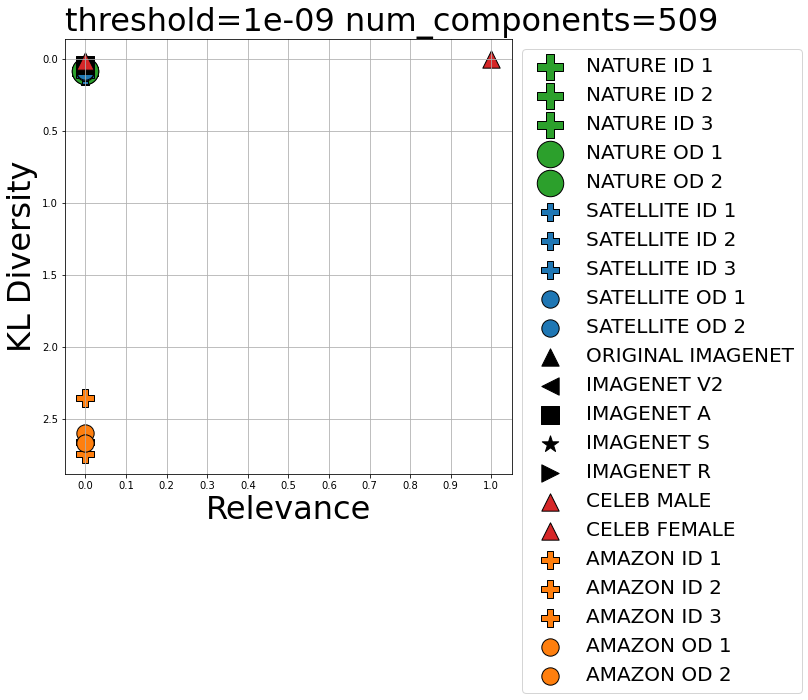

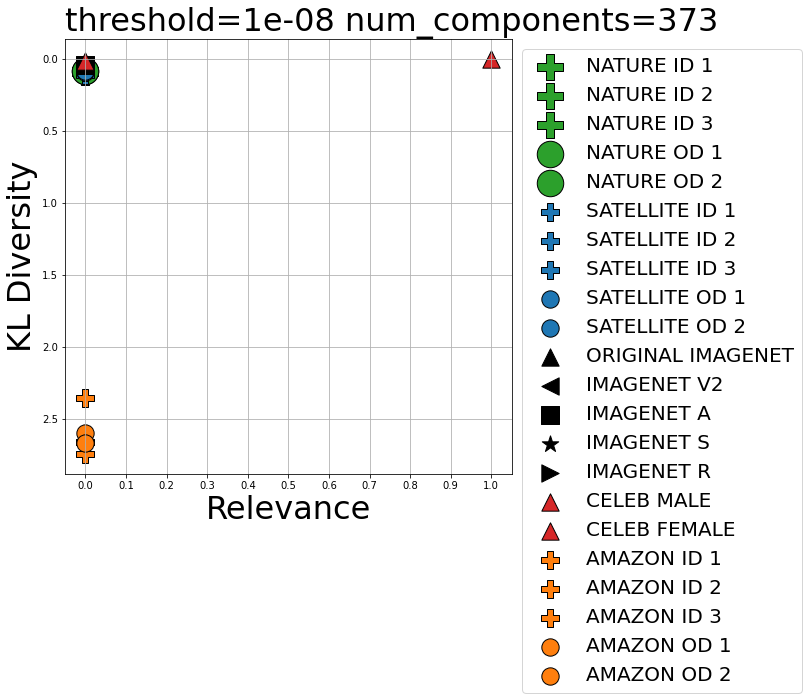

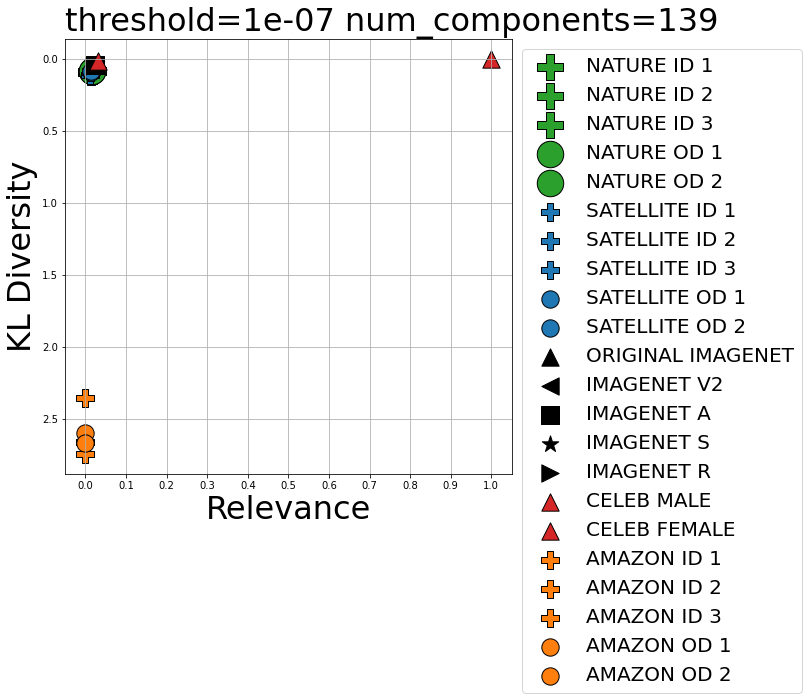

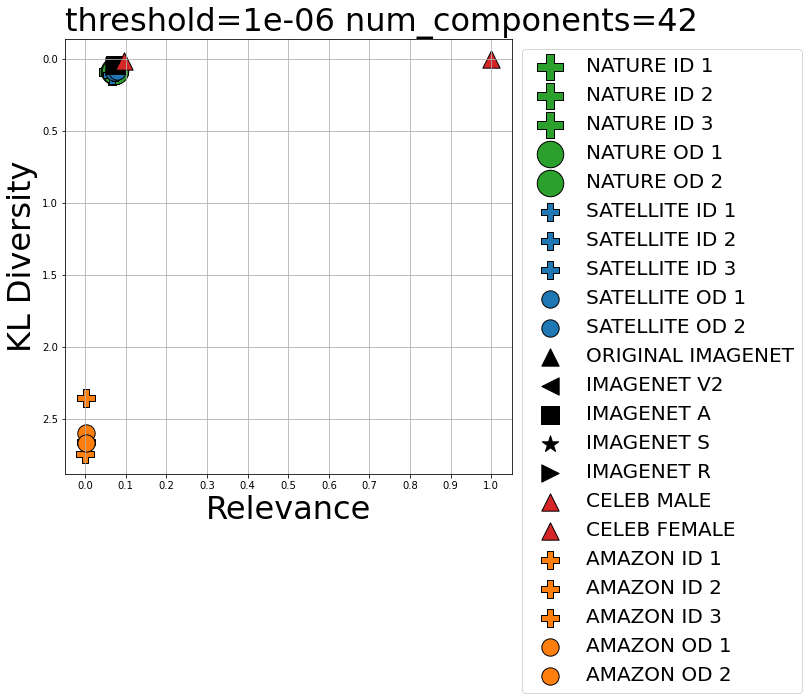

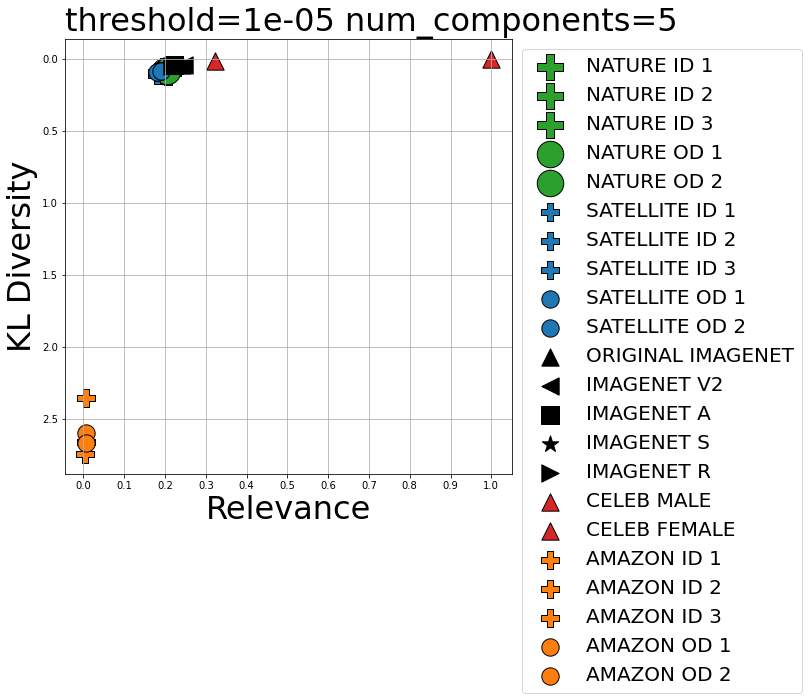

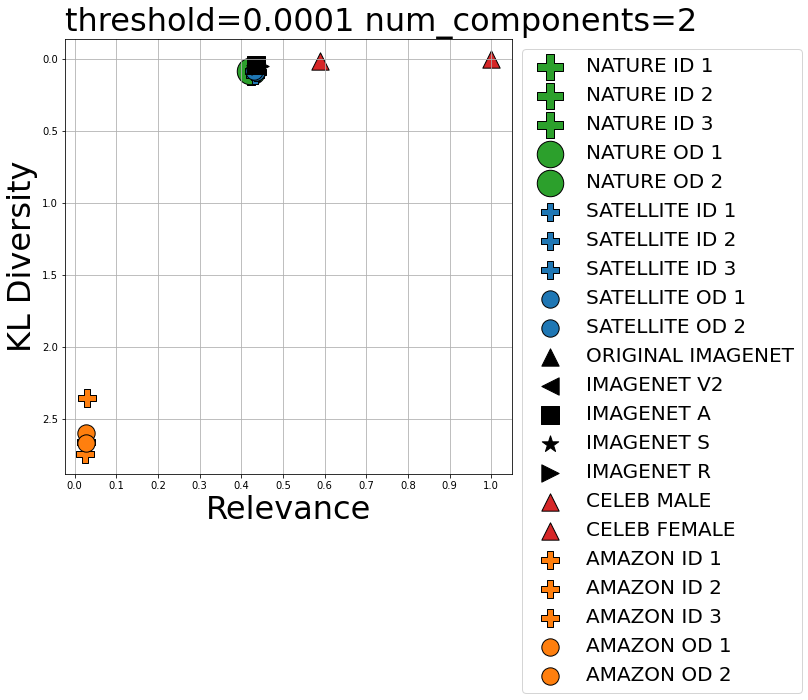

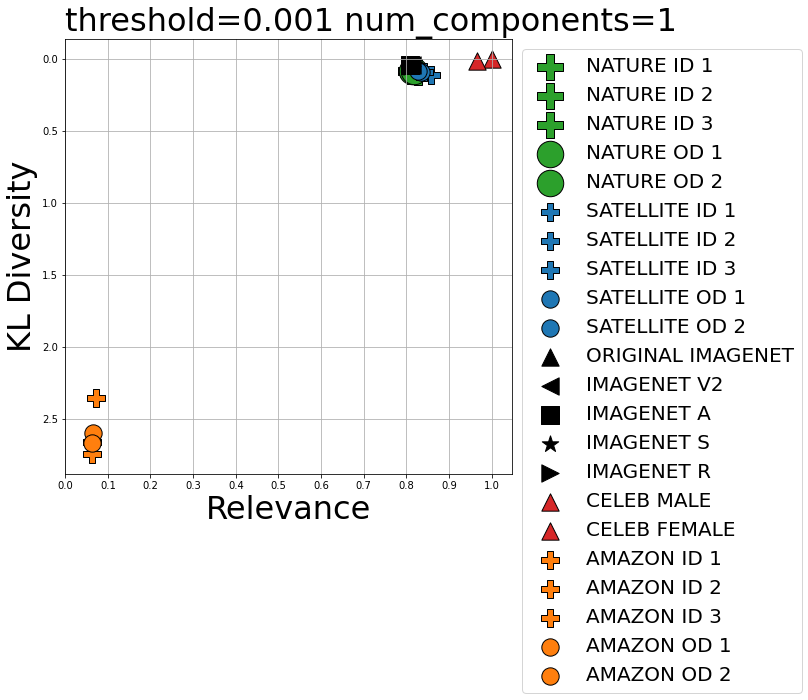

ZeroDivisionError: division by zero

In [134]:
# buyer = 'imagenet'
buyer = 'male'
# buyer = 'iwildcam'
# buyer = 'fmow'
# buyer = 'amazon'

if buyer == 'imagenet':
    buyer_features = clip_imagenet_val_features 
elif buyer == 'male':
    buyer_features = clip_male_features
elif buyer == 'iwildcam':
    buyer_features = clip_iwildcam_id_train_features 
elif buyer == 'fmow':
    buyer_features = clip_fmow_id_train_features
elif buyer == 'amazon':
    buyer_features = clip_amazon_id_train_features
else:
    raise ValueError()

buyer_scores = torch.softmax(buyer_features.float(), 1)
buyer_cov = utils.covariance(buyer_scores.numpy().astype(np.float64))
buyer_eig_val, buyer_eig_vec = utils.svd(buyer_cov)

sellers_features = {
    'NATURE ID 1': clip_iwildcam_id_train_features,
    'NATURE ID 2': clip_iwildcam_id_val_features,
    'NATURE ID 3': clip_iwildcam_id_test_features,
    'NATURE OD 1': clip_iwildcam_od_val_features,
    'NATURE OD 2': clip_iwildcam_od_test_features,
    'SATELLITE ID 1': clip_fmow_id_train_features,
    'SATELLITE ID 2': clip_fmow_id_val_features,
    'SATELLITE ID 3': clip_fmow_id_test_features, 
    'SATELLITE OD 1': clip_fmow_od_val_features,
    'SATELLITE OD 2': clip_fmow_od_test_features, 
    'ORIGINAL IMAGENET': clip_imagenet_val_features,
    'IMAGENET V2': clip_imagenet_v2_features,
    'IMAGENET A': clip_imagenet_a_features,
    'IMAGENET S': clip_imagenet_s_features,
    'IMAGENET R': clip_imagenet_r_features,
    'CELEB MALE': clip_male_features,
    'CELEB FEMALE': clip_female_features,
    'AMAZON ID 1': clip_amazon_id_train_features,
    'AMAZON ID 2': clip_amazon_id_val_features,
    'AMAZON ID 3': clip_amazon_id_test_features,
    'AMAZON OD 1': clip_amazon_od_val_features,
    'AMAZON OD 2': clip_amazon_od_test_features,
}

sellers_scores = {k: torch.softmax(v.float(), 1) for k, v in sellers_features.items()}
sellers_cov = {k: utils.covariance(v.numpy().astype(np.float64)) for k, v in sellers_scores.items()}

reload(utils)

# use_kl = False
use_kl = True

# thresholds = (1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3)
thresholds = (1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2)

# for num_components in components:
for threshold in thresholds:
    seller_rel = {}
    seller_div = {}

    for seller, seller_cov in sellers_cov.items():
        # div, rel, num_components = utils.div_rel_func(buyer_eig_val, buyer_eig_vec, seller_cov, num_components=num_components)
        div, rel, num_components = utils.div_rel_func(buyer_eig_val, buyer_eig_vec, seller_cov, threshold=threshold)
        if use_kl:
            div = utils.KL_divergence(sellers_scores[seller].mean(0), buyer_scores.mean(0)) 

        seller_rel[seller] = rel
        seller_div[seller] = div

    s = 300
    plt.figure(figsize=(8, 8))
    for seller in sellers_cov.keys():
        if 'ID' in seller:
            marker = 'P'
        elif 'OD' in seller:
            marker = 'o'
        elif 'IMAGENET V2' in seller:
            marker = '<'
        elif 'IMAGENET A' in seller:
            marker = 's'
        elif 'IMAGENET S' in seller:
            marker = '*'
        elif 'IMAGENET R' in seller:
            marker = '>'
        else:
            marker = '^'

        if 'SATELLITE' in seller:
            c = 'C0'
            s = 300
        elif 'NATURE' in seller:
            c = 'C2'
            s = 700
        elif 'AMAZON' in seller:
            c = 'C1'
            s = 300
        elif 'CELEB' in seller:
            c = 'C3'
            s = 300
        else:
            c = 'k'
            s = 300

        rel = seller_rel[seller]
        div = seller_div[seller]
        plt.scatter(rel, div, marker=marker,  s=s, label=seller, c=c, edgecolor='black')

    if use_kl:
        plt.gca().invert_yaxis()
        plt.ylabel('KL Diversity', fontsize=32)
    else:
        plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
        plt.ylabel('Diversity', fontsize=32)

    # plt.title(f'number of components: {num_components}', fontsize=32)
    plt.title(f'{threshold=} {num_components=}', fontsize=32, loc='left')
    plt.xlabel('Relevance', fontsize=32)
    plt.legend(prop={'size': 20}, bbox_to_anchor=(1.00, 1.00))
    plt.grid(True)
    if not use_kl:
        plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

    plt.savefig(figure_dir / f'clip-{buyer}-{str(num_components).zfill(5)}-kl-{use_kl}.png', bbox_inches='tight')
    plt.show()

### old

In [111]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)
train_preprocessing = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # normalize,
])
test_preprocessing = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # normalize,
])

In [112]:
reload(utils)

n = 5000

kwargs = dict(eval_mode=True, transforms=train_preprocessing, test_transforms=test_preprocessing)

val_ds = utils.DS(img_val, class_df=df.copy(), **kwargs)
v2_ds = utils.DS(img_v2, class_df=df.copy(), domain=None, **kwargs)
a_ds = utils.DS(img_a, class_df=df.copy(), domain=None, **kwargs)
r_ds = utils.DS(img_r, class_df=df.copy(), domain=None, **kwargs)
s_ds = utils.DS(img_s, class_df=df.copy(), domain=None, **kwargs)

found 50000 images
found 10000 images
found 7500 images
found 30000 images
found 50889 images


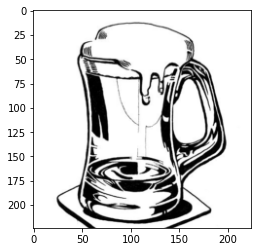

In [117]:
plt.imshow(s_ds[3][0].moveaxis(0, -1).numpy())

In [118]:
reload(utils)
celeb = data_dir / 'celeba_hq/val'
male = celeb / 'male'
female = celeb / 'female'
male_ds = utils.DS(male, **kwargs)
female_ds = utils.DS(female, **kwargs)

found 1000 images
found 1000 images


In [119]:
reload(utils)
import medmnist

med_dir = data_dir / 'medmnist'
blood = medmnist.BloodMNIST('test', root=med_dir, download=True)
breast = medmnist.BreastMNIST('test', root=med_dir, download=True)
chest = medmnist.ChestMNIST('test', root=med_dir, download=True)
pneum = medmnist.PneumoniaMNIST('test', root=med_dir, download=True)
retina = medmnist.RetinaMNIST('test', root=med_dir, download=True)
tissue = medmnist.TissueMNIST('test', root=med_dir, download=True)

Using downloaded and verified file: ../data/medmnist/bloodmnist.npz
Using downloaded and verified file: ../data/medmnist/breastmnist.npz
Using downloaded and verified file: ../data/medmnist/chestmnist.npz
Using downloaded and verified file: ../data/medmnist/pneumoniamnist.npz
Using downloaded and verified file: ../data/medmnist/retinamnist.npz
Using downloaded and verified file: ../data/medmnist/tissuemnist.npz


In [120]:
simple_preprocessing = transforms.Compose([
    transforms.Lambda(lambda img: img[:, :, None].repeat(3, -1) if img.ndim == 2 else img),
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # normalize,
])

In [121]:
blood_ds = utils.simple_DS(blood.imgs, blood.labels, transforms=simple_preprocessing)
breast_ds = utils.simple_DS(breast.imgs, breast.labels, transforms=simple_preprocessing)
chest_ds = utils.simple_DS(chest.imgs, chest.labels, transforms=simple_preprocessing)
pneum_ds = utils.simple_DS(pneum.imgs, pneum.labels, transforms=simple_preprocessing)
retina_ds = utils.simple_DS(retina.imgs, retina.labels, transforms=simple_preprocessing)
tissue_ds = utils.simple_DS(tissue.imgs, tissue.labels, transforms=simple_preprocessing)

In [122]:
# plt.imshow(blood_ds[0][0].moveaxis(0, -1).numpy())

In [123]:
reload(utils)
n = 10

val_scores = utils.evaluate(model, val_ds, num_batches=n)
v2_scores = utils.evaluate(model, v2_ds, num_batches=n)
a_scores = utils.evaluate(model, a_ds, num_batches=n)
r_scores = utils.evaluate(model, r_ds, num_batches=n)
s_scores = utils.evaluate(model, s_ds, num_batches=n)

blood_scores = utils.evaluate(model, blood_ds, num_batches=n)
breast_scores = utils.evaluate(model, breast_ds, num_batches=n)
chest_scores = utils.evaluate(model, chest_ds, num_batches=n)
pneum_scores = utils.evaluate(model, pneum_ds, num_batches=n)
tissue_scores = utils.evaluate(model, tissue_ds, num_batches=n)
retina_scores = utils.evaluate(model, retina_ds, num_batches=n)

male_scores = utils.evaluate(model, male_ds, num_batches=n)
female_scores = utils.evaluate(model, female_ds, num_batches=n)

11it [00:05,  1.89it/s]                                                                                                                 
11it [00:05,  1.95it/s]                                                                                                                 
11it [00:04,  2.21it/s]                                                                                                                 
11it [00:05,  2.11it/s]                                                                                                                 
11it [00:07,  1.54it/s]                                                                                                                 
  0%|                                                                                                            | 0/10 [00:00<?, ?it/s]/home/luchar/.pyenv/versions/3.10.8/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the re

In [124]:
print(male_scores.shape)
print(tissue_scores.shape)
print(s_scores.shape)
print(a_scores.shape)

(352, 11221)
(352, 11221)
(352, 11221)
(352, 11221)


In [125]:
print(val_scores.min(), val_scores.mean(), val_scores.max())
print(blood_scores.min(), blood_scores.mean(), blood_scores.max())
print(chest_scores.min(), chest_scores.mean(), chest_scores.max())
print(male_scores.min(), male_scores.mean(), male_scores.max())
print(female_scores.min(), female_scores.mean(), female_scores.max())

-10.786688 -2.2700322 13.186177
-9.0703945 -2.319135 8.648485
-7.9823723 -2.190491 8.962612
-10.374168 -2.376893 10.109713
-7.859803 -2.1547 11.374912


In [126]:
val_scores = torch.softmax(torch.tensor(val_scores), 1)
v2_scores = torch.softmax(torch.tensor(v2_scores), 1)
a_scores = torch.softmax(torch.tensor(a_scores), 1)
r_scores = torch.softmax(torch.tensor(r_scores), 1)
s_scores = torch.softmax(torch.tensor(s_scores), 1)

blood_scores = torch.softmax(torch.tensor(blood_scores), 1)
breast_scores = torch.softmax(torch.tensor(breast_scores), 1)
chest_scores = torch.softmax(torch.tensor(chest_scores), 1)
pneum_scores = torch.softmax(torch.tensor(pneum_scores), 1)
retina_scores = torch.softmax(torch.tensor(retina_scores), 1)
tissue_scores = torch.softmax(torch.tensor(tissue_scores), 1)

male_scores = torch.softmax(torch.tensor(male_scores), 1)
female_scores = torch.softmax(torch.tensor(female_scores), 1)

In [127]:
val_cov = utils.covariance(val_scores)
v2_cov = utils.covariance(v2_scores)
a_cov = utils.covariance(a_scores)
r_cov = utils.covariance(r_scores)
s_cov = utils.covariance(s_scores)

blood_cov = utils.covariance(blood_scores)
breast_cov = utils.covariance(breast_scores)
chest_cov = utils.covariance(chest_scores)
pneum_cov = utils.covariance(pneum_scores)
retina_cov = utils.covariance(retina_scores)
tissue_cov = utils.covariance(tissue_scores)

male_cov = utils.covariance(male_scores)
female_cov = utils.covariance(female_scores)

In [128]:
from time import perf_counter

In [129]:
start = perf_counter()
buyer_cov = val_cov
buyer_eig_val, buyer_eig_vec = utils.svd(buyer_cov)
end = perf_counter()
print(end - start)

533.5004969416186


In [130]:
print((end - start) / 60)

8.891674949026976


In [131]:
for threshold in (1e3, 1e2, 1e1, 1e-1, 1e-2, 1e-3, 1e-4):
    print((buyer_eig_val >= threshold).sum())

0
0
0
0
1
30
185


In [132]:
sellers = {
    # 'original imagenet': val_cov, 
    'imagenet-V2': v2_cov, 
    'imagenet-A': a_cov, 
    'imagenet-R': r_cov, 
    'imagenet-S': s_cov, 
    'blood': blood_cov, 
    'breast': breast_cov, 
    'chest': chest_cov, 
    'pneum': pneum_cov, 
    'retina': retina_cov, 
    'tissue': tissue_cov, 
    'male': male_cov, 
    'female': female_cov, 
}

threshold = 1e-4
# threshold = 1e-3
# threshold = 1e-2
# threshold = 1e-1
# threshold = 1
# threshold = 10

seller_rel = {}
seller_div = {}

for seller, seller_cov in sellers.items():
    print(seller)
    div, rel, _ = utils.div_rel_func(buyer_eig_val, buyer_eig_vec, seller_cov, threshold=threshold)
    seller_rel[seller] = rel
    seller_div[seller] = div

imagenet-V2
imagenet-A
imagenet-R
imagenet-S
blood
breast
chest
pneum
retina
tissue
male
female


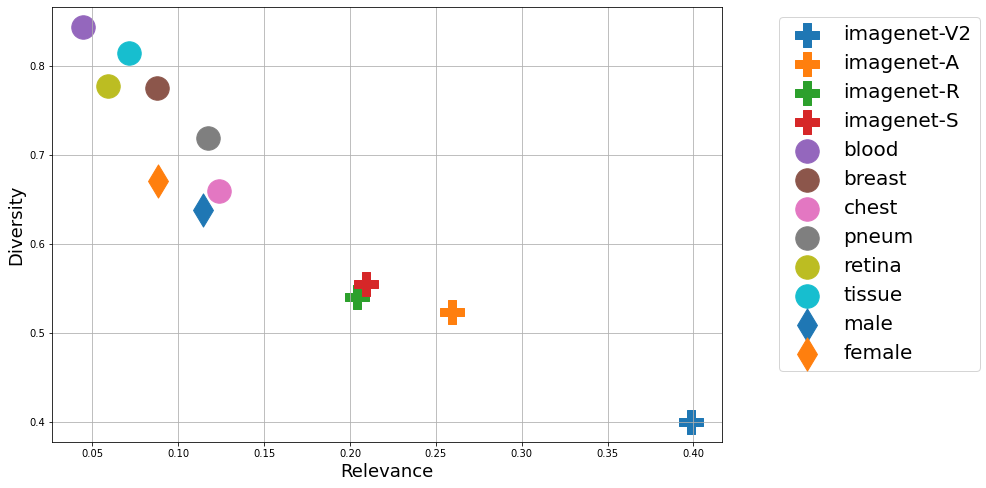

In [133]:
s = 550
plt.figure(figsize=(12, 8))
for seller in sellers.keys():
    if 'imagenet' in seller:
        marker = 'P'
    elif 'male' in seller:
        marker = 'd'
    else:
        marker = 'o'
    
    rel = seller_rel[seller]
    div = seller_div[seller]
    plt.scatter(rel, div, marker=marker,  s=s, label=seller)
# plt.scatter(source_a_rel, source_a_div, marker='o',  s=s, color='green',  label='Before (Imagenet-A)')
# plt.scatter(target_a_rel, target_a_div, marker='P',  s=s, color='green',  label='After (Imagenet-A)')
# plt.scatter(source_s_rel, source_s_div, marker='o',  s=s, color='gold',  label='Before (Imagenet-Sketch)')
# plt.scatter(target_s_rel, target_s_div, marker='P',  s=s, color='gold',  label='After (Imagenet-Sketch)')
# plt.scatter(source_r_rel, source_r_div, marker='o',  s=s, color='purple',  label='Before (Imagenet-R)')
# plt.scatter(target_r_rel, target_r_div, marker='P',  s=s, color='purple',  label='After (Imagenet-R)')
# plt.scatter(source_v2_rel, source_v2_div, marker='o',  s=s, color='red',  label='Before (Imagenet-V2)')
# plt.scatter(target_v2_rel, target_v2_div, marker='P',  s=s, color='red',  label='After (Imagenet-V2)')


# plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance', fontsize=18)
plt.ylabel('Diversity', fontsize=18)
plt.legend(prop={'size': 20}, bbox_to_anchor=(1.40, 1.00))
plt.grid(True)
# plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# plt.savefig('imagenet.png', bbox_inches='tight', )
plt.show()

In [52]:
# plt.imshow(female_ds[0].moveaxis(0, -1).numpy())

In [86]:
import pydicom 

data_path = Path('../data/CANDID-PTX/')
dicom_path = list((data_path/'dataset').iterdir())
df = pd.read_csv(data_path/'Pneumothorax_reports.csv')

root='../data/medmnist'
mnist = tensor(MNIST('../data/', train=True, download=False, transform=transforms.Normalize((0.1307,), (0.3081,))).data[:n])
cifar = CIFAR10('../data/', train=True, download=False).data[:n]
chest = ChestMNIST('train', root=root, download=False).imgs[:n][:, :, :, None].repeat(3, 3) 
pneumonia = PneumoniaMNIST('train', root=root, download=False).imgs[:n] 
blood = BloodMNIST('train', root=root, download=False).imgs[:n] 
tissue = TissueMNIST('train', root=root, download=False).imgs[:n][:, :, :, None].repeat(3, 3) 

dicom_images = [pydicom.dcmread(data_path/'dataset'/df.iloc[i].SOPInstanceUID).pixel_array for i in range(100)]

FileNotFoundError: [Errno 2] No such file or directory: '../data/CANDID-PTX/dataset'

In [3]:
model_path = Path('models')
model_path.mkdir(exist_ok=True)
scores_path = Path('scores')
scores_path.mkdir(exist_ok=True)

In [4]:
torch.cuda.is_available()

True

In [50]:
inet_v2_train_1, inet_v2_train_2 = subsample(inet_v2_train, n=len(inet_v2_train), test_split=test_split)
inet_a_train_1, inet_a_train_2 = subsample(inet_a_train, n=len(inet_a_train), test_split=test_split)
inet_r_train_1, inet_r_train_2 = subsample(inet_r_train, n=len(inet_r_train), test_split=test_split)
inet_s_train_1, inet_s_train_2 = subsample(inet_s_train, n=len(inet_s_train), test_split=test_split)

1875
1875
1875
1875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


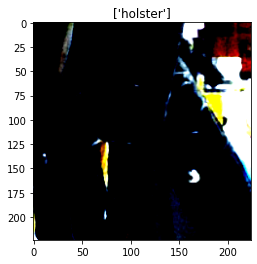

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


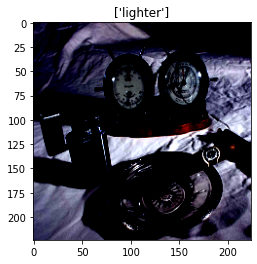

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


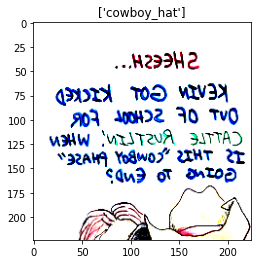

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


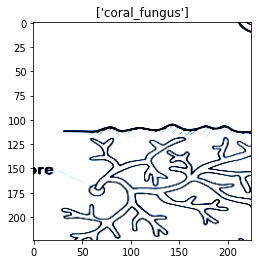

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


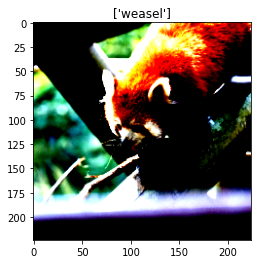

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


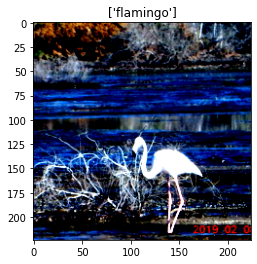

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


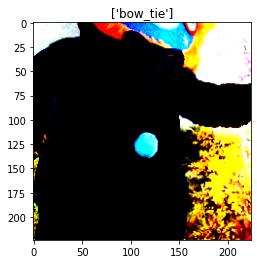

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


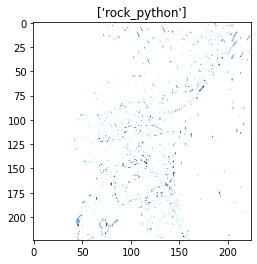

In [51]:
k = 1
# for ds in (inet_val, inet_v2_train, inet_a_train, inet_r_train, inet_s_train):
for ds in (inet_v2_train, inet_a_train, inet_r_train, inet_s_train):
    x, y = ds[k]
    plt.title(df[df.class_index == y].class_name.values)
    plt.imshow(x.moveaxis(0, -1))
    plt.show()

for ds in (inet_v2_test, inet_a_test, inet_r_test, inet_s_test):
    x, y = ds[k]
    plt.title(df[df.class_index == y].class_name.values)
    plt.imshow(x.moveaxis(0, -1))
    plt.show()

In [11]:
def create_model(arch='eff-b1',  num_classes = 1000):
    if arch == 'eff-b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    elif arch == 'eff-b1':
        model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
    elif arch == 'eff-b2':
        model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
    elif arch == 'eff-b3':
        model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
    elif arch == 'eff-b4':
        model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
        
    model = model.cuda()
    return model

def create_optimizer(model, lr = 1e-5):
    opt = optim.AdamW(model.parameters(),lr=lr)
    return opt

In [42]:
inet_s_train

In [13]:
val_loader = torch.utils.data.DataLoader(inet_val, batch_size=32, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
v2_train_loader = torch.utils.data.DataLoader(ConcatDataset([inet_v2_train, inet_train]), batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
v2_test_loader = torch.utils.data.DataLoader(inet_v2_test, batch_size=32, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
a_train_loader = torch.utils.data.DataLoader(ConcatDataset([inet_a_train, inet_train]), batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
a_test_loader = torch.utils.data.DataLoader(inet_a_test, batch_size=32, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
s_train_loader = torch.utils.data.DataLoader(ConcatDataset([inet_s_train, inet_train]), batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
s_test_loader = torch.utils.data.DataLoader(inet_s_test, batch_size=32, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
r_train_loader = torch.utils.data.DataLoader(ConcatDataset([inet_r_train, inet_train]), batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
r_test_loader = torch.utils.data.DataLoader(inet_r_test, batch_size=32, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to /home/luchar/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-533bc792.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████| 30.1M/30.1M [00:00<00:00, 39.3MB/s]


Final T_scaling factor: 0.83


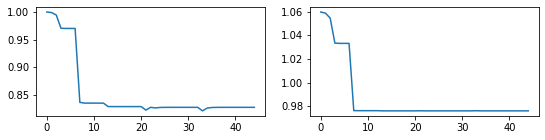

In [16]:
val_logits, val_labels = evaluate(val_model, val_loader)

val_temp = temp_scale(val_logits, val_labels)

In [125]:
# epochs = 50

# source_v2_test_logits, source_v2_test_labels = evaluate(v2_model, v2_test_loader)
# v2_loss = update(v2_model, v2_opt, crit, v2_train_loader, epochs=epochs, save_name=f'v2_model_{n}_samples')
# target_v2_test_logits, target_v2_test_labels = evaluate(v2_model, v2_test_loader)

# source_a_test_logits, source_a_test_labels = evaluate(a_model, a_test_loader)
# a_loss = update(a_model, a_opt, crit, a_train_loader, epochs=epochs, save_name=f'imagenet_a_model_{n}_samples')
# target_a_test_logits, target_a_test_labels = evaluate(a_model, a_test_loader)

# source_r_test_logits, source_r_test_labels = evaluate(r_model, r_test_loader)
# r_loss = update(r_model, r_opt, crit, r_train_loader, epochs=epochs, save_name=f'imagenet_r_model_{n}_samples')
# target_r_test_logits, target_r_test_labels = evaluate(r_model, r_test_loader)

# source_s_test_logits, source_s_test_labels = evaluate(s_model, s_test_loader)
# s_loss = update(s_model, s_opt, crit, s_train_loader, epochs=epochs, save_name=f'imagenet_s_model_{n}_samples')
# target_s_test_logits, target_s_test_labels = evaluate(s_model, s_test_loader)

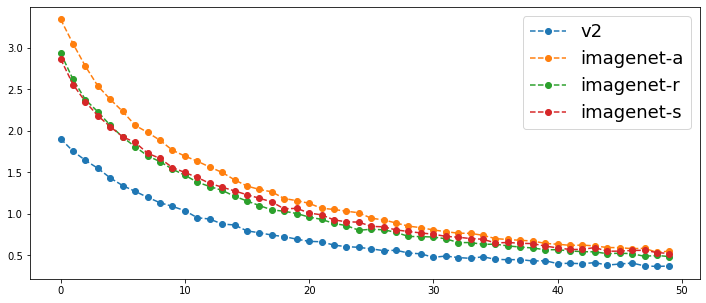

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(v2_loss[0], 'o--', label='v2')
plt.plot(a_loss[0], 'o--', label='imagenet-a')
plt.plot(r_loss[0], 'o--', label='imagenet-r')
plt.plot(s_loss[0], 'o--', label='imagenet-s')
plt.legend(fontsize=18)
plt.show()

In [21]:
# val_softmax = torch.softmax(val_logits / val_temp, 1)

# source_v2_softmax = torch.softmax(source_v2_test_logits / val_temp, 1)
# source_a_softmax = torch.softmax(source_a_test_logits / val_temp, 1)
# source_r_softmax = torch.softmax(source_r_test_logits / val_temp, 1)
# source_s_softmax = torch.softmax(source_s_test_logits / val_temp, 1)

# target_v2_softmax = torch.softmax(target_v2_test_logits / val_temp, 1)
# target_a_softmax = torch.softmax(target_a_test_logits / val_temp, 1)
# target_r_softmax = torch.softmax(target_r_test_logits / val_temp, 1)
# target_s_softmax = torch.softmax(target_s_test_logits / val_temp, 1)

sm = lambda x: torch.softmax(torch.tensor(x), 1)
val_softmax = sm(val_logits)

source_v2_softmax = sm(source_v2_test_logits )
source_a_softmax = sm(source_a_test_logits )
source_r_softmax = sm(source_r_test_logits )
source_s_softmax = sm(source_s_test_logits )

target_v2_softmax = sm(target_v2_test_logits )
target_a_softmax = sm(target_a_test_logits )
target_r_softmax = sm(target_r_test_logits )
target_s_softmax = sm(target_s_test_logits )

In [23]:
buyer_cov = cov(val_softmax)
buyer_eig_val, buyer_eig_vec = svd(buyer_cov)

source_a_cov = cov(source_a_softmax)
target_a_cov = cov(target_a_softmax)
source_s_cov = cov(source_s_softmax)
target_s_cov = cov(target_s_softmax)
source_r_cov = cov(source_r_softmax)
target_r_cov = cov(target_r_softmax)
source_v2_cov = cov(source_v2_softmax)
target_v2_cov = cov(target_v2_softmax)

threshold = 1e-3

buyer_div, buyer_rel, count = div_rel_func(buyer_eig_val, buyer_eig_vec, buyer_cov, threshold=threshold)
source_a_div, source_a_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, source_a_cov, threshold=threshold)
target_a_div, target_a_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, target_a_cov, threshold=threshold)
source_s_div, source_s_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, source_s_cov, threshold=threshold)
target_s_div, target_s_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, target_s_cov, threshold=threshold)
source_r_div, source_r_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, source_r_cov, threshold=threshold)
target_r_div, target_r_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, target_r_cov, threshold=threshold)
source_v2_div, source_v2_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, source_v2_cov, threshold=threshold)
target_v2_div, target_v2_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, target_v2_cov, threshold=threshold)

print('self')
print(f'{buyer_div:.3f}', f'{buyer_rel:.3f}')
print(count)
print('imagenet-a')
print(f'{source_a_div:.3f}', f'{source_a_rel:.3f}')
print(f'{target_a_div:.3f}', f'{target_a_rel:.3f}')
print('imagenet-s')
print(f'{source_s_div:.3f}', f'{source_s_rel:.3f}')
print(f'{target_s_div:.3f}', f'{target_s_rel:.3f}')
print('imagenet-r')
print(f'{source_r_div:.3f}', f'{source_r_rel:.3f}')
print(f'{target_r_div:.3f}', f'{target_r_rel:.3f}')
print('imagenet-v2')
print(f'{source_v2_div:.3f}', f'{source_v2_rel:.3f}')
print(f'{target_v2_div:.3f}', f'{target_v2_rel:.3f}')


s = 250
plt.figure()
plt.scatter(buyer_rel, buyer_div, marker='s',  s=s, color='blue',  label='Buyer (Original Imagenet)')
plt.scatter(source_a_rel, source_a_div, marker='o',  s=s, color='green',  label='Before (Imagenet-A)')
plt.scatter(target_a_rel, target_a_div, marker='P',  s=s, color='green',  label='After (Imagenet-A)')
plt.scatter(source_s_rel, source_s_div, marker='o',  s=s, color='gold',  label='Before (Imagenet-Sketch)')
plt.scatter(target_s_rel, target_s_div, marker='P',  s=s, color='gold',  label='After (Imagenet-Sketch)')
plt.scatter(source_r_rel, source_r_div, marker='o',  s=s, color='purple',  label='Before (Imagenet-R)')
plt.scatter(target_r_rel, target_r_div, marker='P',  s=s, color='purple',  label='After (Imagenet-R)')
plt.scatter(source_v2_rel, source_v2_div, marker='o',  s=s, color='red',  label='Before (Imagenet-V2)')
plt.scatter(target_v2_rel, target_v2_div, marker='P',  s=s, color='red',  label='After (Imagenet-V2)')


# plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance', fontsize=18)
plt.ylabel('Diversity', fontsize=18)
plt.legend(prop={'size': 12}, bbox_to_anchor=(0.10, 1.00))
plt.grid(True)
# plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# plt.savefig('imagenet.png', bbox_inches='tight', )
plt.show()

In [27]:
val_target_a_logits, val_target_a_labels = evaluate(a_model, val_loader)
val_target_s_logits, val_target_s_labels = evaluate(s_model, val_loader)
val_target_r_logits, val_target_r_labels = evaluate(r_model, val_loader)
val_target_v2_logits, val_target_v2_labels = evaluate(v2_model, val_loader)

In [28]:
# val_target_a_softmax = torch.softmax(val_target_a_logits / val_temp, 1)
# val_target_r_softmax = torch.softmax(val_target_r_logits / val_temp, 1)
# val_target_s_softmax = torch.softmax(val_target_s_logits / val_temp, 1)
# val_target_v2_softmax = torch.softmax(val_target_v2_logits / val_temp, 1)

val_target_a_softmax = sm(val_target_a_logits  )
val_target_r_softmax = sm(val_target_r_logits  )
val_target_s_softmax = sm(val_target_s_logits  )
val_target_v2_softmax = sm(val_target_v2_logits  )

In [29]:
val_target_a_cov = cov(val_target_a_softmax)
val_target_s_cov = cov(val_target_s_softmax)
val_target_r_cov = cov(val_target_r_softmax)
val_target_v2_cov = cov(val_target_v2_softmax)

val_target_a_div, val_target_a_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, val_target_a_cov, threshold=threshold)
val_target_s_div, val_target_s_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, val_target_s_cov, threshold=threshold)
val_target_r_div, val_target_r_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, val_target_r_cov, threshold=threshold)
val_target_v2_div, val_target_v2_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, val_target_v2_cov, threshold=threshold)

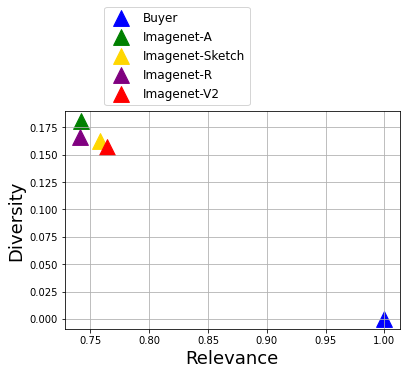

In [30]:
s = 250
plt.figure()
plt.scatter(buyer_rel, buyer_div, marker='^',  s=s, color='blue',  label='Buyer')
plt.scatter(val_target_a_rel, val_target_a_div, marker='^',  s=s, color='green',  label='Imagenet-A')
plt.scatter(val_target_s_rel, val_target_s_div, marker='^',  s=s, color='gold',  label='Imagenet-Sketch')
plt.scatter(val_target_r_rel, val_target_r_div, marker='^',  s=s, color='purple',  label='Imagenet-R')
plt.scatter(val_target_v2_rel, val_target_v2_div, marker='^',  s=s, color='red',  label='Imagenet-V2')


# plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance', fontsize=18)
plt.ylabel('Diversity', fontsize=18)
plt.legend(prop={'size': 12}, bbox_to_anchor=(0.10, 1.00))
plt.grid(True)
# plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.savefig('imagenet-val.png', bbox_inches='tight', )
plt.show()

In [33]:

def accuracy(scores, labels):
    scores = np.asarray(scores)
    labels = np.asarray(labels)
    N = len(labels)
    correct = np.sum(scores.argmax(1) == labels)
    return correct / N

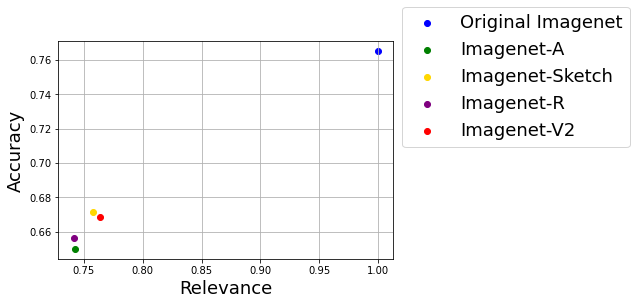

In [34]:
plt.scatter(buyer_rel, accuracy(val_softmax, val_labels), color='blue',  label='Original Imagenet')
plt.scatter(val_target_a_rel, accuracy(val_target_a_softmax, val_target_a_labels), color='green',  label='Imagenet-A')
plt.scatter(val_target_s_rel, accuracy(val_target_s_softmax, val_target_s_labels), color='gold',  label='Imagenet-Sketch')
plt.scatter(val_target_r_rel, accuracy(val_target_r_softmax, val_target_r_labels), color='purple',  label='Imagenet-R')
plt.scatter(val_target_v2_rel, accuracy(val_target_v2_softmax, val_target_v2_labels), color='red',  label='Imagenet-V2')
plt.xlabel('Relevance', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(prop={'size': 18}, bbox_to_anchor=(1.00, 1.20))
plt.grid(True)


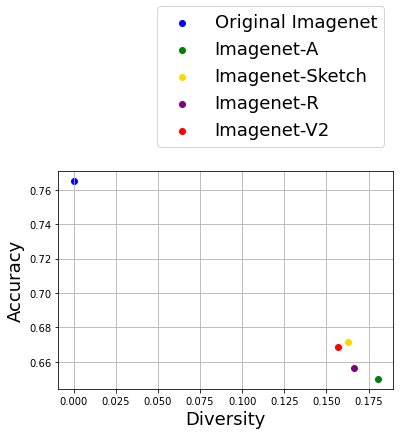

In [35]:
plt.scatter(buyer_div, accuracy(val_softmax, val_labels), color='blue',  label='Original Imagenet')
plt.scatter(val_target_a_div, accuracy(val_target_a_softmax, val_target_a_labels), color='green',  label='Imagenet-A')
plt.scatter(val_target_s_div, accuracy(val_target_s_softmax, val_target_s_labels), color='gold',  label='Imagenet-Sketch')
plt.scatter(val_target_r_div, accuracy(val_target_r_softmax, val_target_r_labels), color='purple',  label='Imagenet-R')
plt.scatter(val_target_v2_div, accuracy(val_target_v2_softmax, val_target_v2_labels), color='red',  label='Imagenet-V2')
plt.xlabel('Diversity', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(prop={'size': 18}, bbox_to_anchor=(1.00, 1.80))
plt.grid(True)

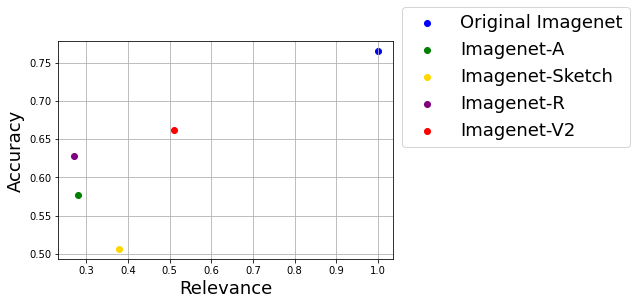

In [36]:
plt.scatter(buyer_rel, accuracy(val_softmax, val_labels), color='blue',  label='Original Imagenet')
plt.scatter(target_a_rel, accuracy(target_a_softmax, target_a_test_labels), color='green',  label='Imagenet-A')
plt.scatter(target_s_rel, accuracy(target_s_softmax, target_s_test_labels), color='gold',  label='Imagenet-Sketch')
plt.scatter(target_r_rel, accuracy(target_r_softmax, target_r_test_labels), color='purple',  label='Imagenet-R')
plt.scatter(target_v2_rel, accuracy(target_v2_softmax, target_v2_test_labels), color='red',  label='Imagenet-V2')
plt.xlabel('Relevance', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(prop={'size': 18}, bbox_to_anchor=(1.00, 1.20))
plt.grid(True)

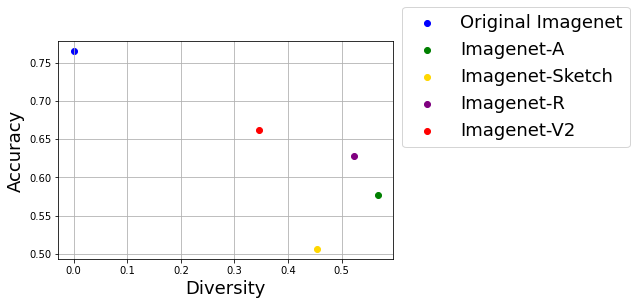

In [37]:
plt.scatter(buyer_div, accuracy(val_softmax, val_labels), color='blue',  label='Original Imagenet')
plt.scatter(target_a_div, accuracy(target_a_softmax, target_a_test_labels), color='green',  label='Imagenet-A')
plt.scatter(target_s_div, accuracy(target_s_softmax, target_s_test_labels), color='gold',  label='Imagenet-Sketch')
plt.scatter(target_r_div, accuracy(target_r_softmax, target_r_test_labels), color='purple',  label='Imagenet-R')
plt.scatter(target_v2_div, accuracy(target_v2_softmax, target_v2_test_labels), color='red',  label='Imagenet-V2')
plt.xlabel('Diversity', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(prop={'size': 18}, bbox_to_anchor=(1.00, 1.20))
plt.grid(True)

In [39]:
pp = lambda new, old: (new - old) / old
pad = 40

def calc_metrics(source_scores, source_labels, target_scores, target_labels, domain=None):
    if domain is not None:
        print('\n', f'{domain}'.center(pad, '='))

    print(f'source accuracy (before retraining)'.ljust(pad, '-'), f' {accuracy(source_scores, source_labels):.1%}')
    print(f'target accuracy (after retraining)'.ljust(pad, '-'), f' {accuracy(target_scores, target_labels):.1%}')
    print(f'accuracy improvement (PPC)'.ljust(pad, '-'), f' {pp(accuracy(target_scores, target_labels), accuracy(source_scores, source_labels)):+.0%}')

    print(f'source average confidence (AC)'.ljust(pad, '-'), f' {AC_metric(source_scores):.2}')
    print(f'target average confidence (AC)'.ljust(pad, '-'), f' {AC_metric(target_scores):.2}')
    print(f'AC improvement (PPC)'.ljust(pad, '-'), f' {pp(AC_metric(target_scores), AC_metric(source_scores)):+.0%}')

    print(f'target difference of confidence (DOC)'.ljust(pad, '-'), f' {DOC_metric(target_scores, source_scores):.2}')
    print(f'target KL '.ljust(pad, '-'), f' {f_metric(target_scores, source_scores):.2}')

calc_metrics(source_a_softmax, source_a_test_labels, target_a_softmax, target_a_test_labels, domain='imagenet-A')
calc_metrics(source_s_softmax, source_s_test_labels, target_s_softmax, target_s_test_labels, domain='imagenet-sketch')
calc_metrics(source_r_softmax, source_r_test_labels, target_r_softmax, target_r_test_labels, domain='imagenet-R')
calc_metrics(source_v2_softmax, source_v2_test_labels, target_v2_softmax, target_v2_test_labels, domain='imagenet-v2')


 ===============imagenet-A===============
source accuracy (before retraining)-----  2.9%
target accuracy (after retraining)------  57.7%
accuracy improvement (PPC)--------------  +1883%
source average confidence (AC)----------  0.37
target average confidence (AC)----------  0.75
AC improvement (PPC)--------------------  +101%
target difference of confidence (DOC)---  0.44
target KL ------------------------------  4.9

 ============imagenet-sketch=============
source accuracy (before retraining)-----  24.9%
target accuracy (after retraining)------  50.6%
accuracy improvement (PPC)--------------  +103%
source average confidence (AC)----------  0.39
target average confidence (AC)----------  0.69
AC improvement (PPC)--------------------  +75%
target difference of confidence (DOC)---  0.38
target KL ------------------------------  3.7

 ===============imagenet-R===============
source accuracy (before retraining)-----  25.6%
target accuracy (after retraining)------  62.8%
accuracy improveme

/tmp/ipykernel_630/3111216590.py:19: RuntimeWarning: divide by zero encountered in log
  res = np.sum(np.where(p!=0, p*np.log(p/q), 0))
/tmp/ipykernel_630/3111216590.py:19: RuntimeWarning: invalid value encountered in multiply
  res = np.sum(np.where(p!=0, p*np.log(p/q), 0))


In [59]:
# source_v2_softmax.mean(0)

In [70]:
a_kl, v2_kl

(0.5886166, 0.88805544)

In [85]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [75]:
n = 100

source_a_cov = cov(source_a_softmax[:n])
source_s_cov = cov(source_s_softmax[:n])
source_r_cov = cov(source_r_softmax[:n])
source_v2_cov = cov(source_v2_softmax[:n])

threshold = 1e-3

buyer_div, buyer_rel, count = div_rel_func(buyer_eig_val, buyer_eig_vec, buyer_cov, threshold=threshold)
source_a_div, source_a_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, source_a_cov, threshold=threshold)
target_a_div, target_a_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, target_a_cov, threshold=threshold)
source_s_div, source_s_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, source_s_cov, threshold=threshold)
target_s_div, target_s_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, target_s_cov, threshold=threshold)
source_r_div, source_r_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, source_r_cov, threshold=threshold)
target_r_div, target_r_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, target_r_cov, threshold=threshold)
source_v2_div, source_v2_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, source_v2_cov, threshold=threshold)
target_v2_div, target_v2_rel, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, target_v2_cov, threshold=threshold)

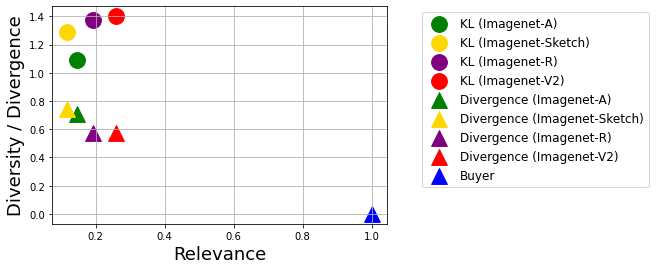

In [83]:
s = 250
plt.figure()
a_kl = KL_divergence(source_a_softmax[:n].mean(0), val_softmax.mean(0)) 
v2_kl = KL_divergence(source_s_softmax[:n].mean(0), val_softmax.mean(0)) 
r_kl = KL_divergence(source_r_softmax[:n].mean(0), val_softmax.mean(0)) 
s_kl = KL_divergence(source_v2_softmax[:n].mean(0), val_softmax.mean(0)) 

plt.scatter(source_a_rel, a_kl, marker='o',  s=s, color='green',  label='KL (Imagenet-A)')
plt.scatter(source_s_rel, v2_kl, marker='o',  s=s, color='gold',  label='KL (Imagenet-Sketch)')
plt.scatter(source_r_rel, r_kl, marker='o',  s=s, color='purple',  label='KL (Imagenet-R)')
plt.scatter(source_v2_rel, s_kl, marker='o',  s=s, color='red',  label='KL (Imagenet-V2)')
plt.scatter(source_a_rel, source_a_div, marker='^',  s=s, color='green',  label='Divergence (Imagenet-A)')
plt.scatter(source_s_rel, source_s_div, marker='^',  s=s, color='gold',  label='Divergence (Imagenet-Sketch)')
plt.scatter(source_r_rel, source_r_div, marker='^',  s=s, color='purple',  label='Divergence (Imagenet-R)')
plt.scatter(source_v2_rel, source_v2_div, marker='^',  s=s, color='red',  label='Divergence (Imagenet-V2)')

plt.scatter(buyer_rel, buyer_div, marker='^',  s=s, color='blue',  label='Buyer')

# plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance', fontsize=18)
# plt.ylabel('Diversity', fontsize=18)
plt.ylabel('Diversity / Divergence', fontsize=18)
plt.legend(prop={'size': 12}, bbox_to_anchor=(1.80, 1.00))
plt.grid(True)
# plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.savefig('imagenet-val.png', bbox_inches='tight', )
plt.show()